# 1.Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers

In [2]:
from sklearn.model_selection import train_test_split

In [3]:

XL=pd.read_csv('9_5day_resampled.csv')
#XU_train=pd.read_csv('9_510_U_resample_95_5.csv')# No resampling done in the unlabeled set, It just denotes the pair of L and U


In [4]:
from sklearn.utils import shuffle
#XU_train.head()

In [5]:
XL.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Fwd.Packet.Length.Max,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,ProtocolName
0,180881369,38752,874422793,80,6,1.494318e+09,86,1,1,0,...,32,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,AMAZON
1,180881347,60112,921084361,80,6,1.494322e+09,117939538,214,242,541,...,32,2104280.0,43740.211271,2135209.0,2073351.0,26398694.5,993864.743909,27101463.0,25695926.0,AMAZON
2,180881370,45916,915964343,80,6,1.494318e+09,101,1,1,0,...,32,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,AMAZON
3,180881370,45075,915964343,80,6,1.494317e+09,140,1,1,0,...,32,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,AMAZON
4,180881370,43447,872483344,80,6,1.494318e+09,118,1,1,0,...,32,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,AMAZON


In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

Using TensorFlow backend.


In [7]:
a=XL.groupby('ProtocolName')['ProtocolName'].count().sort_values(ascending=False)


In [8]:
a   # see resampled instances

ProtocolName
YOUTUBE           6000
SSL               6000
GOOGLE            6000
HTTP              6000
HTTP_CONNECT      6000
HTTP_PROXY        6000
AMAZON            6000
GMAIL             5330
MICROSOFT         5285
EDONKEY           5000
HTTP_DOWNLOAD     5000
WHATSAPP          5000
WIKIPEDIA         5000
H323              5000
GOOGLE_MAPS       5000
WINDOWS_UPDATE    5000
FTP_DATA          5000
FACEBOOK          5000
EBAY              5000
INSTAGRAM         5000
EASYTAXI          5000
DROPBOX           5000
DNS               5000
CONTENT_FLASH     5000
CLOUDFLARE        5000
CITRIX_ONLINE     5000
APPLE_ITUNES      5000
APPLE_ICLOUD      5000
APPLE             5000
UPNP              5000
TWITTER           5000
TOR               5000
RTMP              5000
TEAMVIEWER        5000
TEAMSPEAK         5000
STARCRAFT         5000
SSL_NO_CERT       5000
UBUNTUONE         5000
SSH               5000
SPOTIFY           5000
SKYPE             5000
SIMET             5000
OSCAR             500

In [9]:
'''
Function mask_noise

Input: numpy array , fraction_delete(between 0 and 1)

Removes a fraction_delete fraction of the input array X randomly

Output: numpy array after deletions

'''
def mask_noise(X,fraction_delete=0.2):
    mask=np.random.rand(np.shape(X)[0],np.shape(X)[1])
    mask=1*(mask>fraction_delete)
    return mask*X

In [10]:
'''
Function Gaussian_noise

Input: numpy array , sigma

adds noise distributed normally with a stddev sigma 

Output: numpy array after adding noise

'''
def Gaussian_noise(X,sigma=0.5):
    noise = np.random.normal(0,sigma,np.shape(X))
    return noise+X

In [11]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import load_model
import keras
from keras.layers import Dropout

In [12]:
'''
Sparcity Autoencoder's Sparcity Activity Regularization

'''
def kl_divergence(rho, rho_hat):
    return rho * tf.math.log(rho) - rho * tf.math.log(rho_hat+1e-12) + (1 - rho) * tf.math.log(1 - rho) - (1 - rho) * tf.math.log(1 - rho_hat+1e-12)

class SparseActivityRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, p=0.1, sparsityBeta=3):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def __call__(self, x):
        regularization = 0            

        p_hat = K.mean(x, axis=0)
        regularization += self.sparsityBeta * K.sum(kl_divergence(self.p, p_hat))

        return regularization

    def get_config(self):
        return {"name": self.__class__.__name__} 

In [13]:
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder

In [14]:
yL_train=XL.iloc[:,-1]
XL_train=XL.iloc[:,:-1]

In [15]:
yL_train=pd.get_dummies(yL_train)#One-hot_encoding

# Split into train,test and val

#randomly split into train(80%) and val(20%)
XL_train,XL_val,yL_train,yL_val=train_test_split(XL_train,yL_train,random_state=0,test_size=0.2)

#randomly split val into val(10%) and test(10%)
XL_val,XL_test,yL_val,yL_test=train_test_split(XL_val,yL_val,random_state=0,test_size=0.5)

In [16]:
#different test set
dummy = (yL_test.head(pd.read_csv('yL_test_95U-5L.csv').shape[0])*0).reset_index(drop=True)
ytest = pd.read_csv('yL_test_95U-5L.csv')
#dummy converts 24-one hot encoded classes into 54-one hot encoded classes
for i in yL_test.columns:
    if i in ytest.columns:
        dummy[i] = ytest[i]
yL_test = dummy
XL_test = pd.read_csv('XL_test_95U-5L.csv')

 Reversing the one hot encoding for each set to be used for ML methods

In [17]:
yL_train2=yL_train[yL_train==1].stack().reset_index().drop(0,1)['level_1'] # reversing the one hot encoding for each set

In [18]:
yL_val2=yL_val[yL_val==1].stack().reset_index().drop(0,1)['level_1']# reversing the one hot encoding for each set

In [19]:
yL_test2=yL_test[yL_test==1].stack().reset_index().drop(0,1)['level_1']# reversing the one hot encoding for each set

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

#scaling and normalization
scaler=StandardScaler()
XU_train=scaler.fit_transform(XL_train)
XL_train=scaler.fit_transform(XL_train)
XL_val=scaler.transform(XL_val)
XL_test=scaler.transform(XL_test)


# 2. Training the SDAE
#### Training the Encoder parts

In [21]:
from keras_sequential_ascii import keras2ascii
from tensorflow.keras import regularizers
from keras.models import Sequential

In [22]:
from keras import backend as K


In [23]:
'''
Function SDAE
Inputs: numpy array X, list layers,list activations,float rho,int n_epochs,string denoise,float fraction_delete

denoise is the mode of adding noise
rho is the sparcity constraint parameter
layers is a list of no. of hidden nodes in each hidden layer
activations is a list of activations used in each encoding layer

trains each autoencoder layer and outputs all the encoder-layer models.

Output: a list of keras models

'''
def SDAE(X,layers,activations,rho,n_epochs,denoise,fraction_delete=0.2):
    layers.insert(0,len(X[0]))
    #layers.insert(0,len(X_train.iloc[0]))
    ec=[]
    for i in range(len(layers)-1):
        encoding_dim = layers[i+1]

    # this is our input placeholder
        input_ = Input(shape=(layers[i],))
    # define regulariser
        if rho[i] != None: 
            regulariser = SparseActivityRegularizer(rho[i],3)
        else:
            regulariser=None

        # "encoded" is the encoded representation of the input
        encoded = Dense(encoding_dim, activation=activations[i],bias_initializer='random_normal',kernel_initializer='he_uniform',activity_regularizer=regulariser,name='encoder'+str(i+1))(input_)
        
        # "decoded" is the lossy reconstruction of the input
        decoded = Dense(layers[i],activation=None,name='decoder'+str(i+1))(encoded)

        # this model maps an input to its reconstruction
        autoencoder = Model(input_, decoded)

        # this model maps an input to its encoded representation
        encoder = Model(input_, encoded)

        # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(encoding_dim,))

        autoencoder.compile(optimizer=RMSprop(learning_rate=0.001,clipnorm=0.1), loss='mse')
        
        if denoise =='Gauss':
            X_noisy=Gaussian_noise(X,fraction_delete)
        else:
            X_noisy=mask_noise(X,fraction_delete)
        
        print('Training Layer ' + str(i+1)+' : ')
        autoencoder.fit(X_noisy,X,
                epochs=n_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(X,X))
        
        ec.append(encoder)
        X=encoder.predict(X)
    print('All Layers Done!')    
    return ec       

In [24]:
#Train Sparse Stacked Denoising Autoencoder
layers = [100,200,400,50]
activations=['relu','relu','relu','relu']
rho=[0.06,0.06,0.06,0.06]
traint0=time.time()
stacked_layers=SDAE(XU_train,layers,activations,rho,10,'mask',0.02)

Training Layer 1 : 
Train on 222092 samples, validate on 222092 samples
Epoch 1/10
222092/222092 [==============================] - 4s 17us/step - loss: 5.5291 - val_loss: 0.4855
Epoch 2/10
222092/222092 [==============================] - 3s 14us/step - loss: 0.4385 - val_loss: 0.3348
Epoch 3/10
222092/222092 [==============================] - 3s 15us/step - loss: 0.3581 - val_loss: 0.2882
Epoch 4/10
222092/222092 [==============================] - 3s 16us/step - loss: 0.3201 - val_loss: 0.3027
Epoch 5/10
222092/222092 [==============================] - 3s 15us/step - loss: 0.2930 - val_loss: 0.2497
Epoch 6/10
222092/222092 [==============================] - 3s 14us/step - loss: 0.2747 - val_loss: 0.2356
Epoch 7/10
222092/222092 [==============================] - 3s 14us/step - loss: 0.2583 - val_loss: 0.2384
Epoch 8/10
222092/222092 [==============================] - 3s 14us/step - loss: 0.2479 - val_loss: 0.2180
Epoch 9/10
222092/222092 [==============================] - 3s 13us/step

# 3.Training the SoftMax classifier

In [25]:
'''
Performs a Forward Pass through the SDAE

'''
def SDAE_predict(stacked_layers,X):
    for layer in stacked_layers:
        X1=layer.predict(X)
        X=X1
    return X1    

In [26]:
#forward pass through SDAE
XL_train1=SDAE_predict(stacked_layers,XL_train)
XL_val1=SDAE_predict(stacked_layers,XL_val)
XL_test1=SDAE_predict(stacked_layers,XL_test)

### Please skip this section to part 6 If only ML methods are to be tested, The following is the DL NN model

In [27]:
#Train Classifier separately
input1 = Input(shape=(layers[-1],))
L1 = Dense(len(yL_train.columns),activation='softmax')(input1)
classifier=Model(input1,L1)   
classifier.compile(optimizer=SGD(learning_rate=0.1,momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
history=classifier.fit(XL_train1,yL_train,
                epochs=50,
                #batch_size=256, #default batch_size=32
                shuffle=True,
                validation_data=(XL_val1, yL_val))

Train on 222092 samples, validate on 27761 samples
Epoch 1/50
222092/222092 [==============================] - 6s 27us/step - loss: 3.1876 - accuracy: 0.2602 - val_loss: 2.9073 - val_accuracy: 0.3069
Epoch 2/50
222092/222092 [==============================] - 6s 27us/step - loss: 2.7746 - accuracy: 0.3404 - val_loss: 2.6953 - val_accuracy: 0.3637
Epoch 3/50
222092/222092 [==============================] - 6s 27us/step - loss: 2.6176 - accuracy: 0.3800 - val_loss: 2.5718 - val_accuracy: 0.3895
Epoch 4/50
222092/222092 [==============================] - 6s 27us/step - loss: 2.5190 - accuracy: 0.4024 - val_loss: 2.4912 - val_accuracy: 0.4067
Epoch 5/50
222092/222092 [==============================] - 6s 26us/step - loss: 2.4488 - accuracy: 0.4189 - val_loss: 2.4313 - val_accuracy: 0.4306
Epoch 6/50
222092/222092 [==============================] - 6s 26us/step - loss: 2.3955 - accuracy: 0.4316 - val_loss: 2.3873 - val_accuracy: 0.4409
Epoch 7/50
222092/222092 [=============================

# 4. Fine Tuning
#### Fine Tuning Involves removing the sparsity regularizer from all the layers , adding dropout etc and performing backpropagation to improve the overall model accuracy 

In [29]:
# change regularisation settings
a=[]
for i in range(len(stacked_layers)):
    encoder=stacked_layers[i]
    #encoder.layers[-2].activity_regularizer=None  
    encoder.layers[-1].activity_regularizer=None #remove Sparse activity regularizer
    encoder.save('temp.h5')
    encoder=load_model('temp.h5')
    print(encoder.losses)
    a.append(encoder)
    
classifier.save('temp.h5')
classifier=load_model('temp.h5')
print(classifier.losses)
a.append(classifier)    

c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[]
[]
[]
[]
[]


In [30]:
# add dropout till n-2 layers
model=Sequential()
for i in a:
    model.add(i)
    if i != classifier and i != encoder:
        model.add(Dropout(0.02))

In [31]:
model.save('temp.h5')
model=load_model('temp.h5')

c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [32]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
#fine tune model runs for no. of epochs set below
history=model.fit(XL_train,yL_train,
                epochs=750,
                batch_size=256,
                shuffle=True,
                validation_data=(XL_val, yL_val),
                verbose=0)
traint1=time.time()

In [34]:
print("Train_time: "+str(traint1-traint0))

Train_time: 6695.371121406555


In [35]:
test0=time.time()
print(model.evaluate(XL_test,yL_test))
test1=time.time()
print("Test_time: "+str(test1-test0))

12037/12037 [==============================] - 0s 29us/step
[0.6717147101736588, 0.8292763829231262]
Test_time: 0.384021520614624


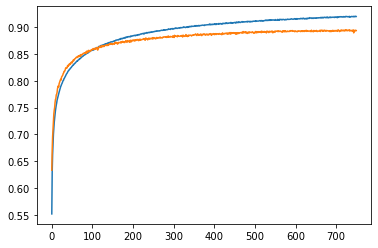

In [36]:
#Visualise convergence with no. of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


# 5. Results
#### Below are the results obtained on our NN model

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [38]:
y_pred=model.predict(XL_test)

In [39]:
y_pred1=y_pred.argmax(axis=1)
y_pred1=np.append(y_pred1,np.arange(54))
y_pred1=pd.get_dummies(y_pred1,columns=yL_train.columns)
y_pred1.columns=yL_test.columns
y_pred1=y_pred1.iloc[:-54]

In [40]:
yL_test.sum()

AMAZON            500
APPLE             474
APPLE_ICLOUD        0
APPLE_ITUNES      515
CITRIX_ONLINE       0
CLOUDFLARE        461
CONTENT_FLASH     494
DNS                 0
DROPBOX           487
EASYTAXI            0
EBAY              508
EDONKEY             0
FACEBOOK          473
FTP_DATA            0
GMAIL             501
GOOGLE            550
GOOGLE_MAPS         0
H323                0
HTTP              491
HTTP_CONNECT      490
HTTP_DOWNLOAD       0
HTTP_PROXY        533
INSTAGRAM           0
IP_ICMP             0
IP_OSPF             0
LASTFM              0
MICROSOFT         497
MQTT                0
MSN               497
MSSQL               0
MS_ONE_DRIVE        0
NETFLIX             0
NTP                 0
OFFICE_365        522
OSCAR               0
RTMP                0
SIMET               0
SKYPE             491
SPOTIFY             0
SSH                 0
SSL               517
SSL_NO_CERT         0
STARCRAFT           0
TEAMSPEAK           0
TEAMVIEWER          0
TOR       

In [41]:
y_test1 = yL_test.columns[np.where(yL_test!=0)[1]]

In [42]:
y_pred1=y_pred1.columns[np.where(y_pred1!=0)[1]]
y_pred1

Index(['WINDOWS_UPDATE', 'APPLE', 'APPLE_ITUNES', 'OFFICE_365', 'MICROSOFT',
       'WIKIPEDIA', 'CLOUDFLARE', 'NETFLIX', 'EBAY', 'MSN',
       ...
       'WINDOWS_UPDATE', 'YAHOO', 'HTTP_CONNECT', 'GMAIL', 'HTTP', 'MSN',
       'GMAIL', 'TWITTER', 'WHATSAPP', 'SKYPE'],
      dtype='object', length=12037)

In [43]:
cm=confusion_matrix(y_test1,y_pred1,labels=yL_test.columns)

In [44]:
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=yL_test.columns,index=yL_test.columns)
cm_pc=cm_pc.replace(np.nan,0)


c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


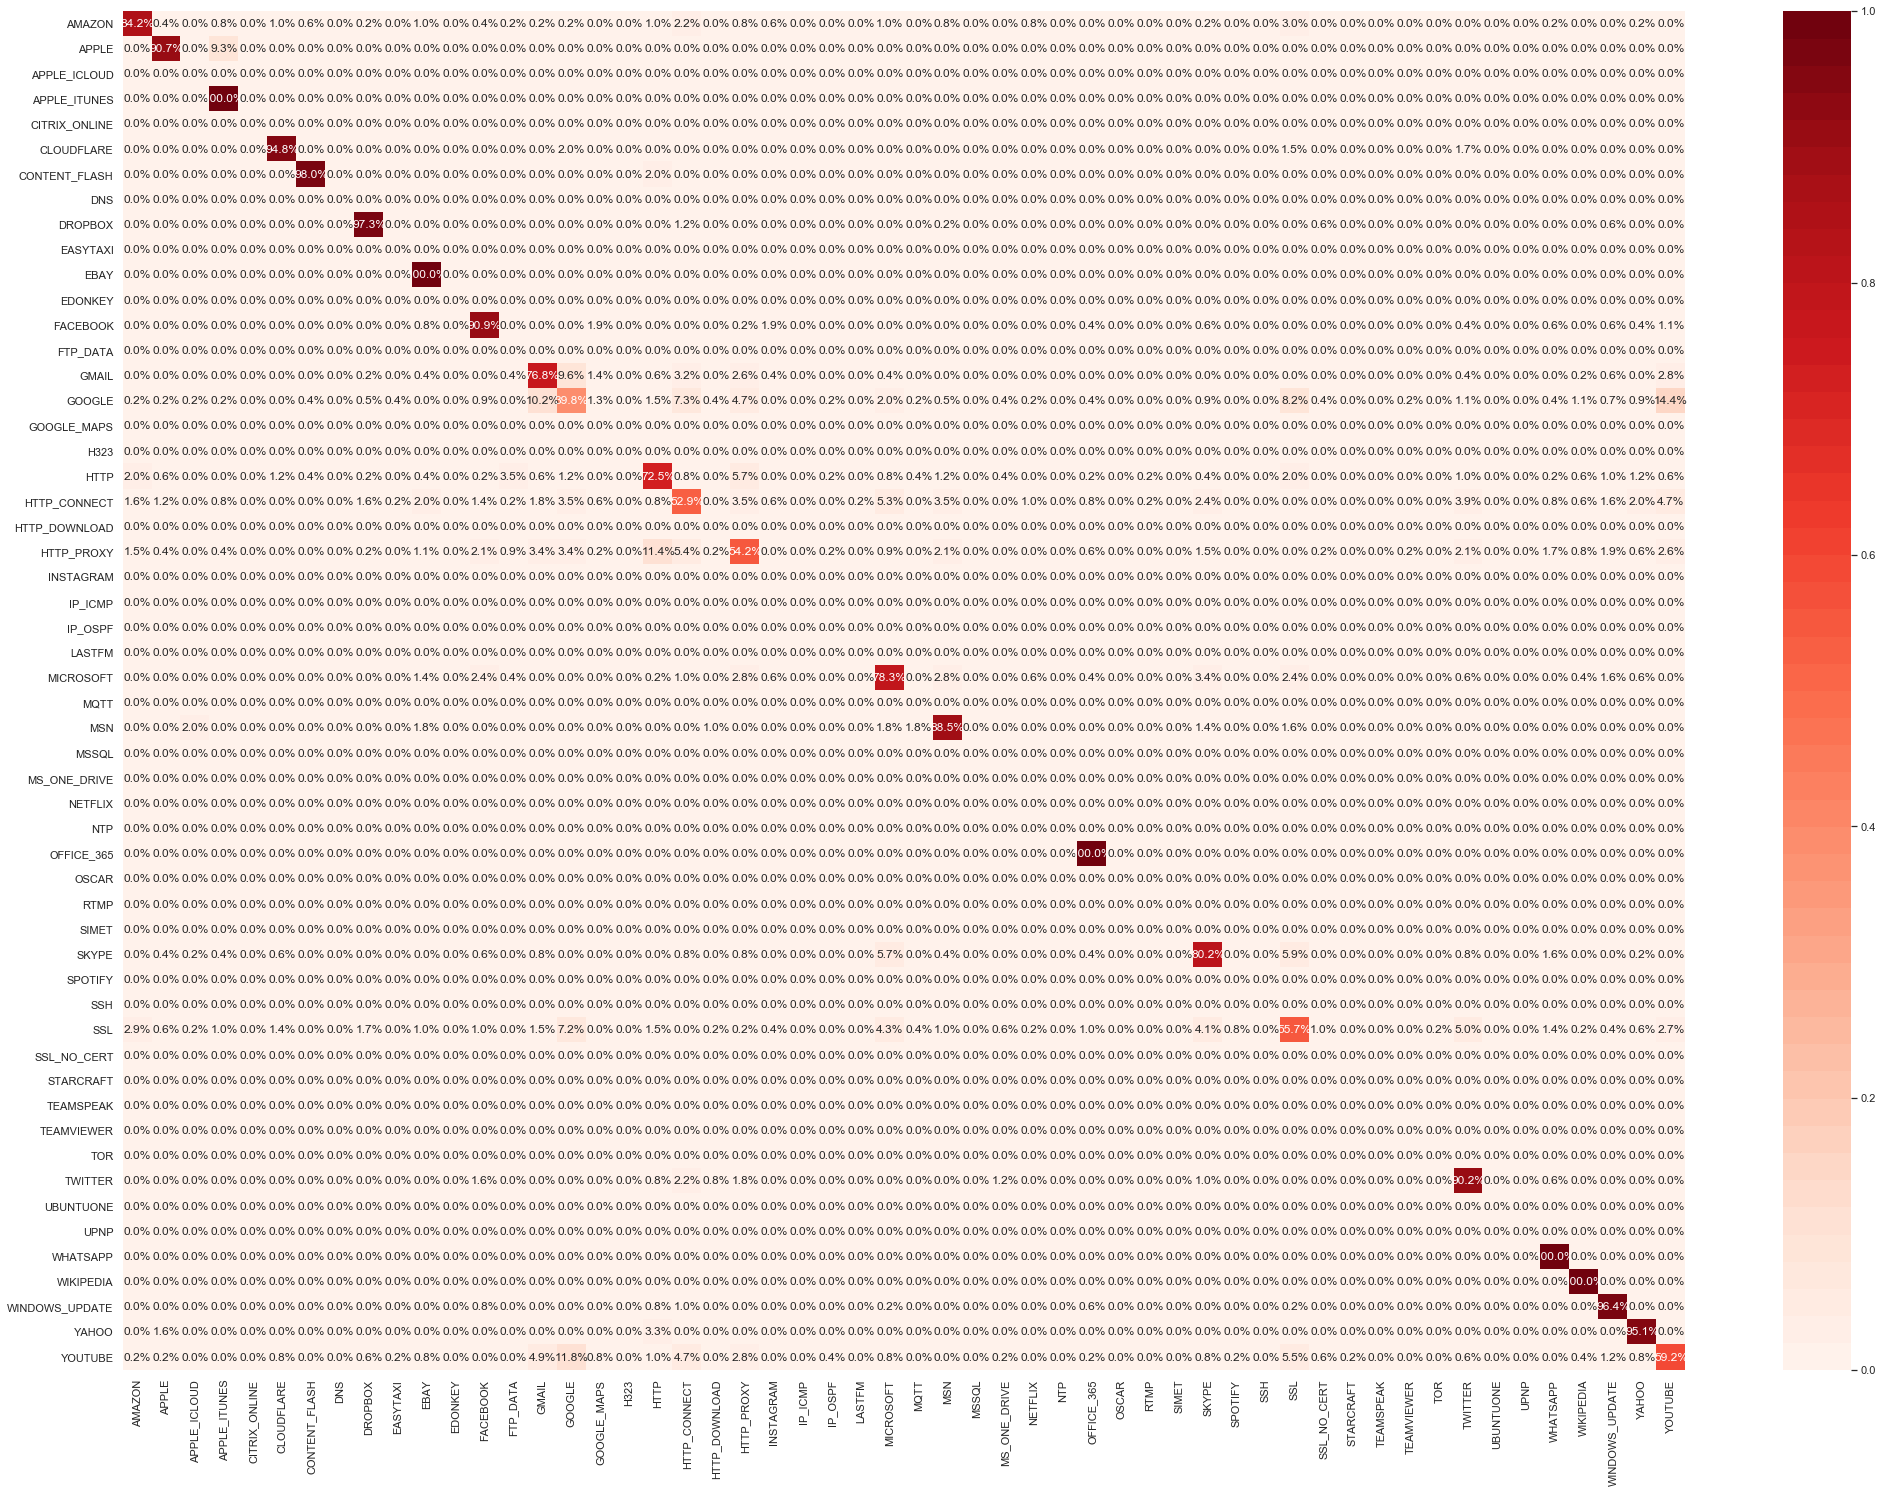

In [45]:
# Plot confusion matrix
plt.figure(figsize=(35,25))
df_cm=pd.DataFrame(cm,columns=yL_test.columns,index=yL_test.columns)
sns.set(font_scale=1.0)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",50)) # font size
plt.show()

In [46]:
print('Test Accuracy : '+str(accuracy_score(y_test1, y_pred1)))

Test Accuracy : 0.8292763977735316


In [47]:
print('weighted F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'weighted')))
print('Macro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'macro')))
print('Micro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'micro')))
print('F1 Scores : ' )
pd.DataFrame(f1_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['F1-score'],index=yL_test.columns)

weighted F1 Score : 0.8293751920828161
Macro F1 Score : 0.4866299593841758
Micro F1 Score : 0.8292763977735316
F1 Scores : 


c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,F1-score
AMAZON,0.873444
APPLE,0.922747
APPLE_ICLOUD,0.000000
APPLE_ITUNES,0.943223
CITRIX_ONLINE,0.000000
CLOUDFLARE,0.946912
CONTENT_FLASH,0.982741
DNS,0.000000
DROPBOX,0.959514
EASYTAXI,0.000000


In [48]:
len(yL_train.columns)# No. of distinct labels

54

In [49]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [50]:
print('Weighted Precision : '+str(precision_score(y_test1, y_pred1,average="weighted")))
print('Macro Precision : '+str(precision_score(y_test1, y_pred1,average="macro")))
print('Micro Precision : '+str(precision_score(y_test1, y_pred1,average="micro")))
print('Precision Scores : ' )
pd.DataFrame(precision_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['Precision-score'],index=yL_test.columns)

Weighted Precision : 0.8325331844456951
Macro Precision : 0.48840228596205093
Micro Precision : 0.8292763977735316
Precision Scores : 


c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision-score
AMAZON,0.842000
APPLE,0.907173
APPLE_ICLOUD,0.000000
APPLE_ITUNES,1.000000
CITRIX_ONLINE,0.000000
CLOUDFLARE,0.947939
CONTENT_FLASH,0.979757
DNS,0.000000
DROPBOX,0.973306
EASYTAXI,0.000000


In [51]:
print('Weighted Recall : '+str(recall_score(y_test1, y_pred1,average="weighted")))
print('Macro Recall : '+str(recall_score(y_test1, y_pred1,average="macro")))
print('Micro Recall : '+str(recall_score(y_test1, y_pred1,average="micro")))
print('Recall Scores : ' )
pd.DataFrame(recall_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['recall-score'],index=yL_test.columns)

c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Recall : 0.8292763977735316
Macro Recall : 0.4868029104521999
Micro Recall : 0.8292763977735316
Recall Scores : 


,recall-score
AMAZON,0.907328
APPLE,0.938865
APPLE_ICLOUD,0.000000
APPLE_ITUNES,0.892548
CITRIX_ONLINE,0.000000
CLOUDFLARE,0.945887
CONTENT_FLASH,0.985743
DNS,0.000000
DROPBOX,0.946108
EASYTAXI,0.000000


#### Confusion Matrix with 10 chosen well-known classes
Classes : AMAZON, FACEBOOK, GMAIL, GOOGLE, HTTP, OFFICE_365, SKYPE, TWITTER, WHATSAPP, YOUTUBE

In [52]:
from sklearn.metrics import confusion_matrix
apps=['AMAZON','FACEBOOK','GMAIL','GOOGLE','HTTP','OFFICE_365','SKYPE','TWITTER','WHATSAPP','YOUTUBE']#reporting for these well-known Apps
y_test1[y_test1.isin(apps)]
cm=confusion_matrix(y_test1[y_test1.isin(apps)],y_pred1[y_test1.isin(apps)],labels=y_test1[y_test1.isin(apps)].unique())

In [53]:
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=y_test1[y_test1.isin(apps)].unique(),index=y_test1[y_test1.isin(apps)].unique())
cm_pc=cm_pc.replace(np.nan,0)

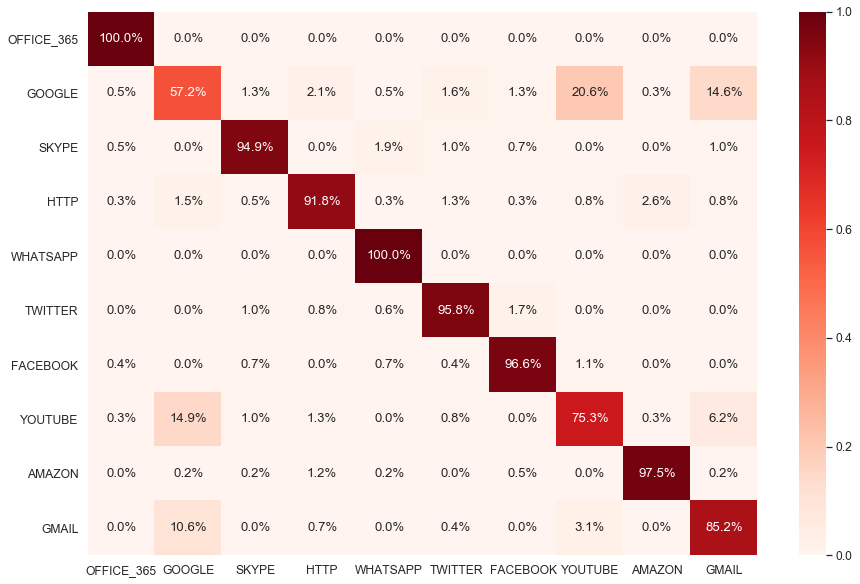

In [54]:
plt.figure(figsize=(15,10))
df_cm=pd.DataFrame(cm,columns=y_test1[y_test1.isin(apps)].unique(),index=y_test1[y_test1.isin(apps)].unique())
sns.set(font_scale=1.1)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",150)) # font size
plt.show()

In [55]:

y_test_restricted = y_test1[y_pred1.isin(ytest.columns)]
y_pred_restricted = y_pred1[y_pred1.isin(ytest.columns)]

In [56]:
print('Macro F1 : '+str(f1_score(y_test_restricted, y_pred_restricted ,average="macro")))
print('Macro Precision : '+str(precision_score(y_test_restricted, y_pred_restricted ,average="macro")))
print('Macro Recall : '+str(recall_score(y_test_restricted, y_pred_restricted ,average="macro")))

Macro F1 : 0.837060911787677
Macro Precision : 0.8343539051851702
Macro Recall : 0.8427278760728454
